***Deep Learning Applications 2023** course, held by Professor **Andrew David Bagdanov** - University of Florence, Italy*

*Notebook and code created by **Giovanni Colombo** - Mat. 7092745*

Check the dedicated [Repository on GitHub](https://github.com/giovancombo/DLA-Labs/tree/main/lab2).

# Deep Learning Applications: Laboratory #2 - LLMs

In this laboratory we will get our hands dirty working with Large Language Models (e.g. GPT and BERT) to do various useful things. Introductory material for this laboratory was the [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper, which is the basis for all transformer-based LLMs, and this [Andrej Karpathy video](https://www.youtube.com/watch?v=kCc8FmEb1nY), which shows how to build an autoregressive GPT model from the ground up.

## Exercise 1: Warming Up
In this first exercise I trained a *small* autoregressive GPT model for character generation (the one used by Karpathy in his video) to generate text in the style of Dante Aligheri, found at [this link](https://archive.org/stream/ladivinacommedia00997gut/1ddcd09.txt), which contains the entire text of Dante's Divina Commedia. I trained the model for some epochs, monitoring the loss, and generating some text at the end of training.

In [2]:
# Imports and dependencies
import os
import torch
import torch.nn as nn
import torch.optim
import wandb

from transformer import TransformerDecoder

project_name = "DLA_Lab2_LLM"

# Hyperparameters
text = 'divina_commedia'
train_size = 0.7

batch_size = 64             # Batch size = number of independent sequences of text, analyzed in parallel
block_size = 512            # Dimension of an input seuqence of characters, for next character prediction
n_embd = 100                # Embedding dimension for each token
n_heads = 4                 # Number of Self-Attention heads in a Multi-Head Attention block
n_layers = 4                # Number of Blocks of the Transformer
learning_rate = 5e-4
dropout = 0.4

eval_iters = 200
total_steps = 5000
log_interval = 100

# Generation configuration
generation = False
new_tokens = 500           # Number of tokens generated

# Saving configuration
save_model = False
folder = f"1_transformers/{text}"
model_name = "model_" + text + "_bs" + str(batch_size) + "_bl" + str(block_size) + "_ne" + str(n_embd) + "_nh" + str(n_heads) + "_nl" + str(n_layers) + "_lr" + str(learning_rate)

# Creating a configuration dictionary for logging in wandb
config = dict(
    text = text,
    batch_size = batch_size,
    block_size = block_size,
    n_embd = n_embd,
    n_heads = n_heads,
    n_layers = n_layers,
    learning_rate = learning_rate,
    dropout = dropout,
    eval_iters = eval_iters,
    total_steps = total_steps,
    log_interval = log_interval,
    train_size = train_size,)


def build_model(vocab_size, block_size, n_embd, n_heads, n_layers, learning_rate, dropout, device):
    m = TransformerDecoder(vocab_size, block_size, n_embd, n_heads, n_layers, dropout)
    model = m.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Model {model.__class__.__name__} instantiated!\n" + f"Number of parameters: {n_params}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(optimizer)

    return model, criterion, optimizer


# Let's define a function for getting a new batch of random sequences of characters in the text
def get_batch(split, device):
    data = train_data if split == 'train' else val_data

    idx = torch.randint(len(data) - block_size, (batch_size,))      # Drawing a set of batch_size indexes in the text
    x = torch.stack([data[i : i+block_size] for i in idx])          # Stacking block_size characters from each index
    y = torch.stack([data[i+1 : i+block_size+1] for i in idx])      # Creating the targets (= inputs shifted by 1)
    x, y = x.to(device), y.to(device)

    return x, y


# Let's create a function for saving and visualizing train and validation losses
@torch.no_grad()                            # Context Manager for disabling gradient calculation: better memory usage
def estimate_loss(model, device, eval_iters = 10):
    outloss = {}
    outacc = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        accuracies = torch.zeros(eval_iters)
        for k in range(eval_iters):         # Evaluating the losses eval_iters times on different batches
            X, Y = get_batch(split, device)
            logits, targets, loss = model(X, Y)

            # Computing accuracy
            total, correct = 0, 0
            _, pred = torch.max(logits.data, 1)
            total += targets.size(0)
            correct += (pred == targets).sum().item()
            accuracy = 100 * correct / total

            losses[k] = loss.item()
            accuracies[k] = accuracy
        outloss[split] = losses.mean()
        outacc[split] = accuracies.mean()

    return outloss, outacc                  # out = dictionary of train and validation mean losses

# Function for log of validation data at the end of an epoch
def log_validation(epoch, mean_loss, val_loss, mean_accuracy, val_accuracy, step):
    wandb.log({"Train Loss": mean_loss, 
               "Validation Loss": val_loss,
               "Epoch": epoch + 1,
               "Train Accuracy": mean_accuracy, 
               "Validation Accuracy": val_accuracy,}, step = step)


# Training Loop      
def train(model, criterion, optimizer, device):
    # Telling W&B to watch gradients and the model parameters
    wandb.watch(model, criterion, log = "all", log_freq = log_interval)
    example_ct = 0

    print("Starting Training...")
    for step in range(total_steps):
        model.train()
        xb, yb = get_batch('train', device)                 # Sampling a batch of data
        _, _, loss = model(xb, yb)
        
        optimizer.zero_grad(set_to_none = True)
        loss.backward()
        optimizer.step()

        example_ct += batch_size

        if step % log_interval == 0 or step == total_steps - 1:
            losses, accuracies = estimate_loss(model, device, eval_iters = eval_iters)
            log_validation(step, losses['train'], losses['val'], accuracies['train'], accuracies['val'], step)
            print(f"Step {step+1}/{total_steps}:\tTrain Loss = {losses['train']:.4f}; Val Loss = {losses['val']:.4f}\tTrain Accuracy = {accuracies['train']:.2f}%; Val Accuracy = {accuracies['val']:.2f}%")

    print("\nTraining completed!")


# Function for generating new text!
def text_generator(model, new_tokens, block_size, device):
    # context = First character of the generated sequence = (1,1) Tensor of value 0 --> Token embedding for New Line
    context = torch.zeros((1,1), dtype = torch.long, device = device)

    print("\nTEXT GENERATION ACTIVATED! Generating new text...")
    generated_text = decode(model.generate(context, block_size, max_new_tokens = new_tokens)[0].tolist())
    
    print("Text generated!")
    print(generated_text)


if __name__ == '__main__':

    # Device configuration
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    wandb.login()
    print("Initializing Weights & Biases run...")

    # Downloading the Dante's Divina Commedia txt file from the internet
    #!wget https://archive.org/stream/ladivinacommedia00997gut/1ddcd09.txt

    # Opening and reading the content of the input text file
    with open("data/" + text + '.txt', 'r', encoding = 'utf-8') as f:
        text = f.read()
    print("Length of dataset in characters:", len(text))

    # Creating a sorted set of all the unique characters present in the text
    chars = sorted(list(set(text)))
    vocab_size = len(chars)

    # Creating a dictionary for mapping characters to integers and viceversa
    stoi = {ch:i for i,ch in enumerate(chars)}
    itos = {i:ch for i,ch in enumerate(chars)}

    encode = lambda s: [stoi[i] for i in s]
    decode = lambda l: ''.join([itos[i] for i in l])

    # text = list of characters
    # data = list of integers of all the text --> it's our dataset
    data = torch.tensor(encode(text), dtype = torch.long, device = device)

    # Splitting our dataset in train and validation sets
    n = int(train_size*len(data))
    train_data, val_data = data[:n], data[n:]

    with wandb.init(project = project_name, config = config):
        config = wandb.config
        
        # Building model and optimizer
        model, criterion, optimizer = build_model(vocab_size, block_size, n_embd, n_heads, n_layers, learning_rate, dropout, device)

        # Training the model
        train(model, criterion, optimizer, device)
        wandb.unwatch(model)

        # Generating new text from the model trained (optional)
        if generation:
            text_generator(model, new_tokens)

        # Saving the model (optional)
        if save_model:
            if not os.path.exists(folder):
                os.makedirs(folder)
            torch.save(model, f"{folder}/{model_name}.pt")
            print('\nModel saved!')


Device: cuda:0
Initializing Weights & Biases run...
Length of dataset in characters: 186804


Model TransformerDecoder instantiated!
Number of parameters: 547058
Optimizer: AdamW
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0.01
)
Starting Training...


Traceback (most recent call last):
  File "C:\Users\giova\AppData\Local\Temp\ipykernel_33088\98679825.py", line 197, in <module>
    train(model, criterion, optimizer, device)
  File "C:\Users\giova\AppData\Local\Temp\ipykernel_33088\98679825.py", line 126, in train
    _, _, loss = model(xb, yb)
  File "c:\Users\giova\anaconda3\envs\DLA\lib\site-packages\torch\nn\modules\module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "c:\Users\giova\anaconda3\envs\DLA\lib\site-packages\torch\nn\modules\module.py", line 1568, in _call_impl
    result = forward_call(*args, **kwargs)
  File "c:\Users\giova\__UNI\Deep Learning Applications\DLA-Labs\lab2\transformer.py", line 24, in forward
    pos_emb = self.pos_embedding(torch.arange(T))   # (T,C) = (block_size, n_embd)
  File "c:\Users\giova\anaconda3\envs\DLA\lib\site-packages\torch\nn\modules\module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "c:\Users\giova\

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

## Exercise 2: Working with Real LLMs

Our toy GPT can only take us so far. In this exercise we will see how to use the [Hugging Face](https://huggingface.co/) model and dataset ecosystem to access a *huge* variety of pre-trained transformer models.

### Exercise 2.1: Installation and text tokenization

First things first, we need to install the [Hugging Face transformer library](https://huggingface.co/docs/transformers/index):

    conda install -c huggingface -c conda-forge transformers
    
The key classes that you will work with are `GPT2Tokenizer` to encode text into sub-word tokens, and the `GPT2LMHeadModel`. **Note** the `LMHead` part of the class name -- this is the version of the GPT2 architecture that has the text prediction heads attached to the final hidden layer representations (i.e. what we need to **generate** text). 

Instantiate the `GPT2Tokenizer` and experiment with encoding text into integer tokens. Compare the length of input with the encoded sequence length.

**Tip**: Pass the `return_tensors='pt'` argument to the tokenizer to get Pytorch tensors as output (instead of lists).

In [1]:
# Imports and dependencies
import os
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tqdm.auto import tqdm

# Device configuration
device = torch.device('cpu')
print(f"Device: {device}")

c:\Users\giova\anaconda3\envs\DLA\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Device: cpu


In [2]:
# Custom input text to be tokenized
input_text = "Hello World"

# Creating a subword tokenizer from GPT2 pretrained model: new vocab_size = 50,257!
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Converting string inputs to sequences of tokens: let's compare the input length with the encoded sequence length
# It's curious to see the difference between calling tokenizer itself, or its encode/tokenize attributes
tokenized_text = tokenizer.encode(input_text, return_tensors = 'pt')

print(f"Input string:\t\t{input_text}\nTokenized string:\t{tokenized_text}")

vocab.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.95MB/s]
c:\Users\giova\anaconda3\envs\DLA\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\giova\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 1.29MB/s]

Input string:		Hello World
Tokenized string:	tensor([[15496,  2159]])


This GPT2 tokenizer works on a subword level, so what I could notice is that, tipically, inputs are divided into several 2/3/4 words chunks and encoded to a particular integer.
As the input string sequences increases their length, the encoded sequence length increases.
Input sequences of 2/3/4 characters can be encoded to a single integer.

While inputing the sequence *"Hello World"*, I could notice that the tokenizer has a single integer for the whole "Hello" and "World" words, suggesting that many existing english (and not only, maybe) words are encoded to a single integer.

Passing the `return_tensors = 'pt'` argument makes the tokenizer output PyTorch tensors instead of lists.

From the original [Hugging Face Documentation](https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2Tokenizer), we can read that:
> This tokenizer has been trained to treat spaces like parts of the tokens (a bit like sentencepiece) so a word will be encoded differently whether it is at the beginning of the sentence (without space) or not.

Trying to see the behaviour of slightly different versions of the sequence *"Hello World"*, it's possible to notice that:
- *"Hello World"* encodes to tensor([[15496,  2159]])
- *"hello World"* encodes to tensor([[31373,  2159]]) --> Case matters
- *" hello World"* encodes to tensor([[23748,  2159]]) --> Space matters!
- *"HelloWorld"* encodes to tensor([[15496, 10603]])
- *"Hello World "* encodes to tensor([[15496,  2159,   220]]) --> But space character has its own encoding integer when nothing follows it

### Exercise 2.2: Generating Text

There are a lot of ways we can, given a *prompt* in input, sample text from a GPT2 model. Instantiate a pre-trained `GPT2LMHeadModel` and use the [`generate()`](https://huggingface.co/docs/transformers/v4.27.2/en/main_classes/text_generation#transformers.GenerationMixin.generate) method to generate text from a prompt.

**Note**: The default inference mode for GPT2 is *greedy* which might not result in satisfying generated text. Look at the `do_sample` and `temperature` parameters.

In [8]:
# Saving configuration
save_generation = True
folder = '2_textgeneration'

# We can even ask the user to input a text prompt
input_text = "The main goal in life is"         # input("What do you want to say?\n")

# Hyperparameters for text generation
max_new_tokens = 100
do_sample = True
temperature = 1.2
early_stopping = True
no_repeat_ngram_size = 2

# Loading the pretrained model: setting the padding token as the end of sequence token
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id = tokenizer.eos_token_id)

print(f"{model.__class__.__name__} instantiated!\n")
print(f"Input text: {input_text}\nWaiting for the generation of new text...")

# inputs is a Pytorch tensor
tokenized_text = tokenizer(input_text, return_tensors = 'pt')

# Let's generate some text from the input sequence: new_text is a Pytorch tensor
generated_text = tokenizer.decode(model.generate(tokenized_text['input_ids'],
                                                max_new_tokens = max_new_tokens,
                                                do_sample = do_sample,
                                                temperature = temperature,
                                                early_stopping = early_stopping,
                                                no_repeat_ngram_size = no_repeat_ngram_size)[0].tolist())
print("\nText generated!")
print(f"{generated_text}")


# Saving the generated text in a txt file
if save_generation:
    if not os.path.exists(folder):
        os.makedirs(folder)
    with open(f"{folder}/generation_log.txt", 'a') as f:
        f.write(f"HPs: max_new_tokens = {max_new_tokens}, do_sample = {do_sample}, temperature = {temperature}, early_stopping = {early_stopping}, no_repeat_ngram_size = {no_repeat_ngram_size}\n\n")
        f.write(f"Input text: {input_text}\nGenerated text: {generated_text}\n\n- - - - - - - - - - - - - - - -\n")

    print(f'\nText generated saved in \'{folder}/generation_log.txt\'')

GPT2LMHeadModel instantiated!

Input text: The main goal in life is
Waiting for the generation of new text...

Text generated!
The main goal in life is to create the most interesting person in the world in you that everyone can play with. To live this life where people don't care about you if you are going to die that makes any sense. It will take you for them and the person they care for and so on. Life is too simple to go back to.

This is why we created The Hero's Pact™: Live Together for Fun, with The Dazzler Foundation through its foundation of the dazzlers program. We believe

Text generated saved in '2_textgeneration/generation_log.txt'


In order to qualitatively evaluate the performance of the `generate()` function and the effect of its arguments, I decided to fix the text prompt to be the same at every run: *"Who knows if God exists, but for sure I"*

- `do_sample = False, temperature = 1.0`: with no argument tuned, the generation is totally greedy and helds no sense. The text generated is a simple sentence of text repeated over and over until the `max_new_tokens` limit of tokens is reached. When `do_sample` is `False`, it's like having a very low `temperature` value, as sampling (= source of noise) is frozen in favour of a deterministic, greedy approach to generation.
- Setting `do_sample` to `True` unlocks the generation, by allowing sampling of more diverse original sequences of tokens, instead of giving always the same greedy text. The tuning of `temperature` lets the magic happen!
- The higher the `temperature`, the "noisier" and unpredictable the generation will be. Very high temperatures lead to, again, non-sense generation, with wrong words and sequences of random symbols.

## Exercise 3: Reusing Pre-trained LLMs (choose one)

Choose **one** of the following exercises (well, *at least* one). In each of these you are asked to adapt a pre-trained LLM (`GPT2Model` or `DistilBERT` are two good choices) to a new Natural Language Understanding task. A few comments:

+ Since GPT2 is a *autoregressive* model, there is no latent space aggregation at the last transformer layer (you get the same number of tokens out that you give in input). To use a pre-trained model for a classification or retrieval task, you should aggregate these tokens somehow (or opportunistically select *one* to use).

+ BERT models (including DistilBERT) have a special [CLS] token prepended to each latent representation in output from a self-attention block. You can directly use this as a representation for classification (or retrieval).

+ The first *two* exercises below can probably be done *without* any fine-tuning - that is, just training a shallow MLP to classify or represent with the appropriate loss function.

### Exercise 3.1: Training a Text Classifier

Peruse the [text classification datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:text-classification&sort=downloads). Choose a *moderately* sized dataset and use a LLM to train a classifier to solve the problem.

**Note**: A good first baseline for this problem is certainly to use an LLM *exclusively* as a feature extractor and then train a shallow model.

In [19]:
# Imports and dependencies
import itertools
import os

import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from utils import *
from shallowclf import *

# Generalizing code for handling different datasets and models
datasets = ['ag_news', 'dair-ai/emotion']
dataset_name = datasets[0]
labels = ["World", "Sports", "Business", "Science/Tech"] if dataset_name == datasets[0] else ["sadness", "joy", "love", "anger", "fear", "surprise"]
pretrained_model = 'distilbert-base-uncased'

# Features Extraction from the dataset (to be done only the first time: following times we can load the saved features)
extract_features = False         # If True, extracts the features from the dataset and saves them again
batch_size = 64

# Saving configuration
save_classification = False
folder = f'31_textclassification/{dataset_name}'

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


So far, I just tried to fine-tune a pretrained DistilBERT model for the Sequence Classification task.

But for this specific exercise, fine-tuning can be avoided! One hint is to use DistilBERT *only* as a mere feature extractor, and to use a very shallow model (an MLP, or even a Logistic Regression!) on the final representation for the multi-class classification.

Let's try to do so!

The choice of the dataset is crucial for what we're trying to achieve: text classification without having to fine-tune DistilBERT.

Looking at the Hugging Face Datasets, one of the best datasets to use is the *ag_news*: a moderately sized multi-class dataset, with perfectly balanced classes.
But, as always, I cannot feel satisfied with easy things: my attention got captured by the *dair-ai/emotion* dataset too, that, in comparison to the previous one, looks like a real mess! 6 classes, skewed, with not that much data available.

I'll try to face the same challenge using the two datasets, in order to check and report any difference encountered.

Looking at the DistilBertTokenizer, I can see that it's a word level tokenizer, at least for the english language.

In [20]:
# 1) Loading the selected dataset using the load_dataset function from Hugging Face datasets
data = load_dataset(dataset_name)
print(f"Dataset \'{dataset_name}\' loaded!")

# 2) Instantiate the Tokenizer to tokenize the raw data, and the pretrained model
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model)
model = DistilBertModel.from_pretrained(pretrained_model).to(device)

# Loading features and labels from the folder
train_features, test_features, train_labels, test_labels = feature_extractor(data, model, tokenizer,
                                                                                batch_size,
                                                                                folder,
                                                                                extract = extract_features,
                                                                                save = save_classification)

Generating test split: 100%|██████████| 7600/7600 [00:00<00:00, 1092828.36 examples/s]


Dataset 'ag_news' loaded!


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Loading features and labels from '31_textclassification/ag_news'...


In [21]:
# Hyperparameters for the shallow classifier (MLP) instantiated
hidden_size = 512
epochs = 20
learning_rate = 1e-3

# Weighted Loss for handling class imbalance
weighted = False

shallowcls = MLP(hidden_size).to(device)
optimizer = torch.optim.Adam(shallowcls.parameters(), lr = learning_rate)

if weighted:
    weights = torch.tensor([3.43, 2.98, 12.27, 7.41, 8.26, 27.97]).to(device)
else:
    weights = None
criterion = nn.CrossEntropyLoss(weight = weights)

print("Starting Training the MLP...")
training_mlp(shallowcls, optimizer, criterion, epochs, batch_size, train_features, train_labels, test_features, test_labels, device)

Starting Training the MLP...
Epoch 1/20:	Training Loss = 0.3577   Test Accuracy = 90.93%
Epoch 2/20:	Training Loss = 0.3386   Test Accuracy = 91.38%
Epoch 3/20:	Training Loss = 0.3166   Test Accuracy = 91.71%
Epoch 4/20:	Training Loss = 0.2974   Test Accuracy = 91.84%
Epoch 5/20:	Training Loss = 0.2802   Test Accuracy = 91.96%
Epoch 6/20:	Training Loss = 0.2581   Test Accuracy = 92.11%
Epoch 7/20:	Training Loss = 0.2551   Test Accuracy = 92.16%
Epoch 8/20:	Training Loss = 0.2335   Test Accuracy = 92.09%
Epoch 9/20:	Training Loss = 0.2082   Test Accuracy = 92.20%
Epoch 10/20:	Training Loss = 0.1839   Test Accuracy = 92.14%
Epoch 11/20:	Training Loss = 0.1617   Test Accuracy = 91.97%
Epoch 12/20:	Training Loss = 0.1299   Test Accuracy = 92.03%
Epoch 13/20:	Training Loss = 0.1148   Test Accuracy = 91.95%
Epoch 14/20:	Training Loss = 0.1025   Test Accuracy = 92.09%
Epoch 15/20:	Training Loss = 0.0765   Test Accuracy = 92.13%
Epoch 16/20:	Training Loss = 0.0738   Test Accuracy = 92.04%
Epoc

In [22]:
print("Training a Logistic Regression model...")
logreg = LogisticRegression(max_iter = 1500).fit(train_features, train_labels)

print("Model trained! Making predictions on new data...\n")
pred = logreg.predict(test_features)

accuracy = accuracy_score(test_labels, pred)*100
f1 = f1_score(test_labels, pred, average = 'weighted')
precision = precision_score(test_labels, pred, average = 'weighted')
recall = recall_score(test_labels, pred, average = 'weighted')

print(f"Prediction completed!\nTest Accuracy = {accuracy:.2f}%\nF1 Score = {f1:.4f}\nPrecision = {precision:.4f}\nRecall = {recall:.4f}")

Training a Logistic Regression model...
Model trained! Making predictions on new data...

Prediction completed!
Test Accuracy = 91.46%
F1 Score = 0.9146
Precision = 0.9147
Recall = 0.9146


c:\Users\giova\anaconda3\envs\DLA\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


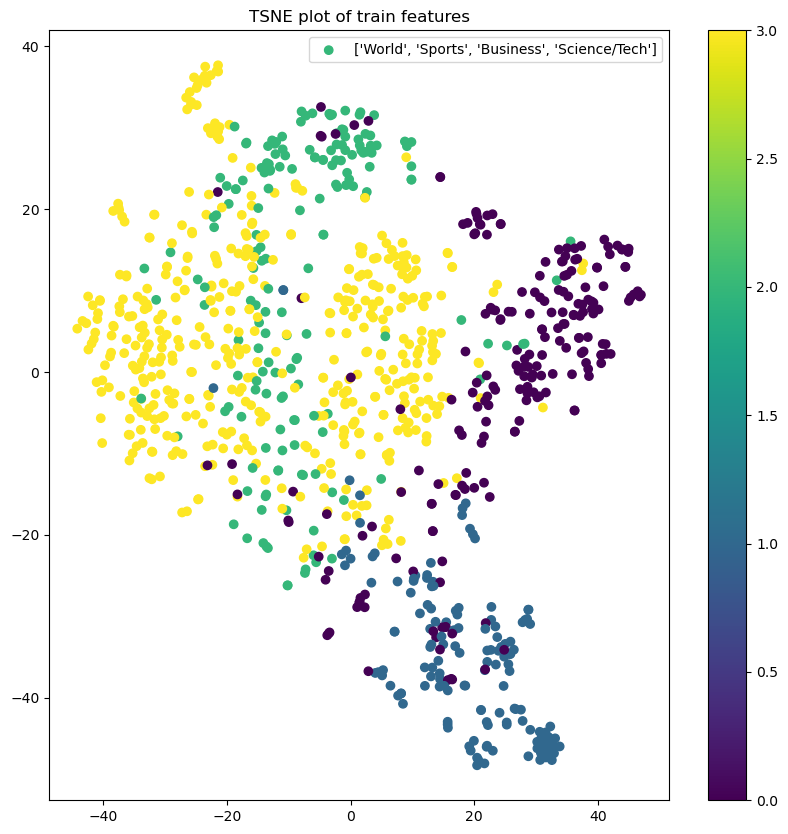

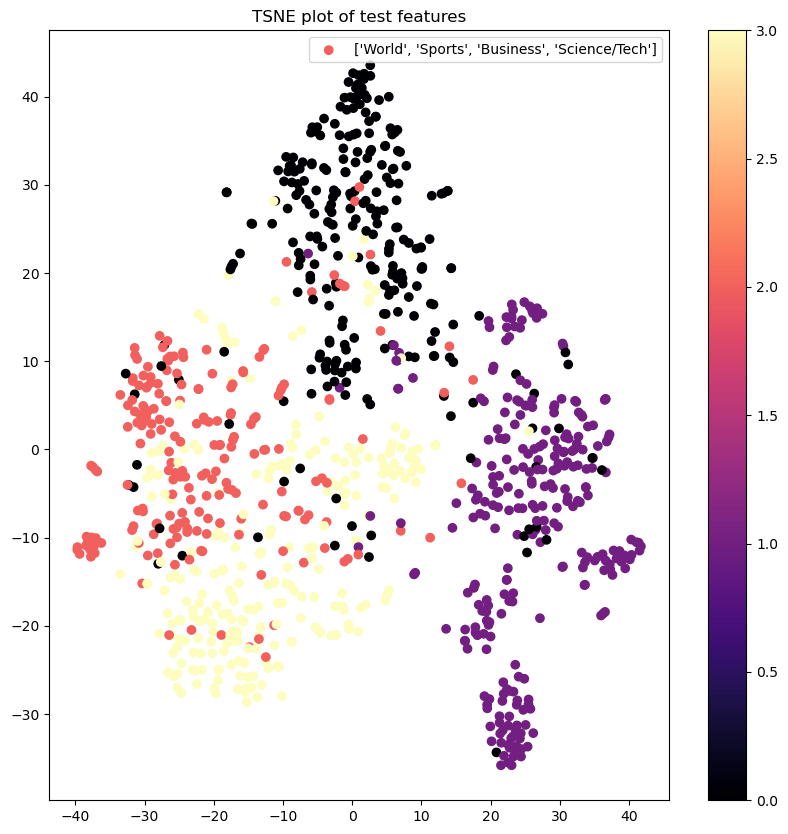

In [23]:
tsne_train = TSNE(n_components = 2, random_state = 1492).fit_transform(train_features[:1000])
plt.figure(figsize = (10, 10))
plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c = train_labels[:1000], label = labels, cmap = "viridis")
plt.title(f"TSNE plot of train features for {dataset_name} Classification")
plt.colorbar()
plt.legend()
plt.savefig(f'images/{dataset_name}-tsne_train.png')
plt.show()

tsne_val = TSNE(n_components = 2, random_state = 1492).fit_transform(test_features[:1000])
plt.figure(figsize = (10, 10))
plt.scatter(tsne_val[:, 0], tsne_val[:, 1], c = test_labels[:1000], label = labels, cmap = "magma")
plt.title(f"TSNE plot of test features for {dataset_name} Classification")
plt.colorbar()
plt.legend()
plt.savefig(f'images/{dataset_name}-tsne_val.png')
plt.show()

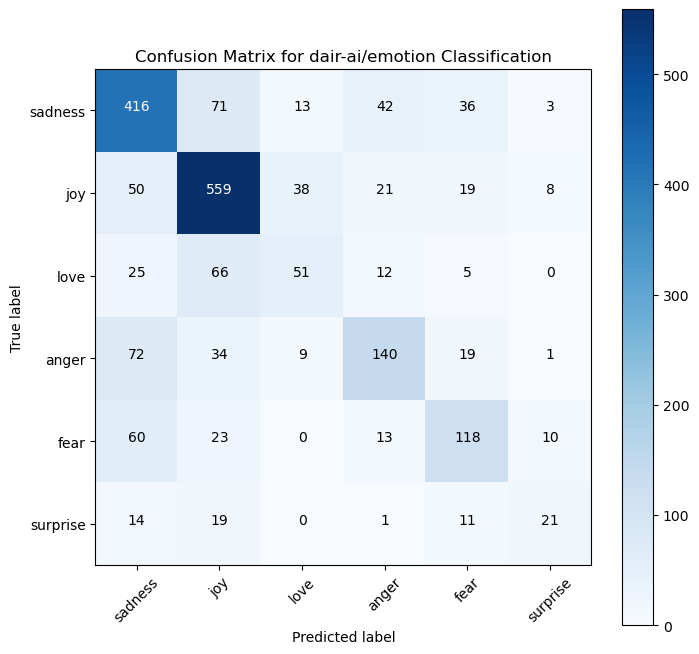

In [18]:
# Create confusion matrix
cm = confusion_matrix(test_labels, pred)
# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for {dataset_name} Classification")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = "d"
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.savefig('images/confusion_matrix.png')
plt.show()

- Using the *dair-ai/emotion* dataset, the multi-class classifier, with or without any tweaks on the loss weights to address the class imbalance problem, struggles to reach 67% Test Accuracy (while a fine-tuned DistilBERT is capable to go up to 94% accuracy).
- Using the *ag_news* dataset, instead, the classifier makes no effort to provide results with 92% Test Accuracy.

Furthermore, results obtained by training a simple MLP and an even simpler Logistic Regression are basically the same.

### Exercise 3.2: Training a Question Answering Model

Peruse the [multiple choice question answering datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:multiple-choice&sort=downloads). Chose a *moderately* sized one and train a model to answer contextualized multiple-choice questions. You *might* be able to avoid fine-tuning by training a simple model to *rank* the multiple choices (see margin ranking loss in Pytorch).

In [ ]:
# Imports and dependencies
import os
import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm.auto import tqdm

# Generalizing code for handling different datasets and models
pretrained_model = 'distilbert-base-uncased'

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(emojize(f"Device: {device} :eagle:") if torch.cuda.is_available() else emojize(f"Device: {device} :snail:")) if emojizer else print(f"Device: {device}")

# Loading the selected dataset (race-middle), Model and Tokenizer
data = load_dataset('race', 'middle')
print(emojize(f"Dataset \'race-middle\' loaded!:OK_hand_medium-light_skin_tone:\n") if emojizer else f"Dataset \'{dataset_name}\' loaded!")

tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
model = AutoModelForSeq2SeqLM.from_pretrained(pretrained_model).to(device)

print(emojize(f"\n{tokenizer.__class__.__name__} and {model.__class__.__name__} instantiated!:OK_hand_medium-light_skin_tone:") if emojizer else f"\n{tokenizer.__class__.__name__} and {model.__class__.__name__} instantiated!")

In [ ]:
data['train']

# input1 = article
# input2 = question

# output1 = answer predicted from article
# output2 = answer predicted from question

# criterion = nn.MarginRankingLoss()
# loss = criterion(output1, output2, target)

### Exercise 3.3: Training a Retrieval Model

The Hugging Face dataset repository contains a large number of ["text retrieval" problems](https://huggingface.co/datasets?task_categories=task_categories:text-retrieval&p=1&sort=downloads). These tasks generally require that the model measure *similarity* between text in some metric space -- naively, just a cosine similarity between [CLS] tokens can get you pretty far. Find an interesting retrieval problem and train a model (starting from a pre-trained LLM of course) to solve it.

**Tip**: Sometimes identifying the *retrieval* problems in these datasets can be half the challenge. [This dataset](https://huggingface.co/datasets/BeIR/scifact) might be a good starting point.

In [ ]:
# Your code here.